<a href="https://colab.research.google.com/github/yourpandaboy/ViV/blob/main/ViV_TJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip      #the mallet file needed
!unzip mallet-2.0.8.zip

In [ ]:
pip install pyLDAvis

In [6]:
import numpy as np
import pandas as pd
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [12]:
df = pd.read_csv("/content/drive/MyDrive/okcupid/okcupid_profiles.csv")

essay0 = df[["essay0"]].dropna() #get essay0 and dropna

data = essay0.essay0.values.tolist() #convert to list for gensim use

In [13]:
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [14]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [ ]:
data_ready = process_words(data)

In [17]:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 43205


In [18]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [19]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
dict_df

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


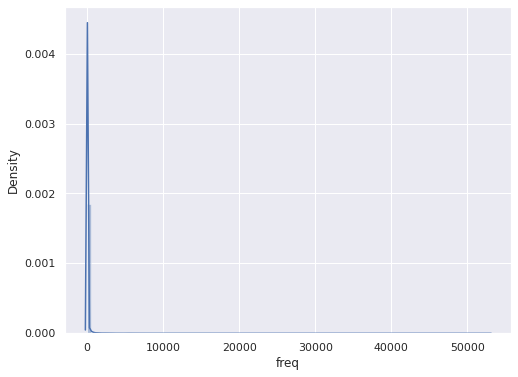

In [23]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [25]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
love,52900
life,28987
people,26882
good,26262
time,25715
thing,25701
get,24817
friend,21670
enjoy,20890
new,19996


In [28]:
extension = dict_df[dict_df.freq>1500].index.tolist()

In [29]:
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

In [30]:
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 42515


In [31]:
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))


Total Vocabulary Size: 9121


In [32]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [34]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [36]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('student', 0.014693944656233623),
   ('degree', 0.014426782026120286),
   ('decide', 0.014262374253742846),
   ('computer', 0.014128792938686177),
   ('build', 0.01158047246683587),
   ('finish', 0.0099158437715143),
   ('state', 0.009843915371099169),
   ('major', 0.009771986970684038),
   ('parent', 0.009073253938079923),
   ('pay', 0.008970499080344023)]),
 (1,
  [('connection', 0.013432187329555435),
   ('energy', 0.011185785732114298),
   ('soul', 0.011185785732114298),
   ('practice', 0.010252096179268394),
   ('playful', 0.009854584785482514),
   ('connect', 0.009836095883445962),
   ('beauty', 0.00971591802020837),
   ('personal', 0.009623473510025607),
   ('spiritual', 0.009540273450861121),
   ('physical', 0.009262939920312832)]),
 (2,
  [('meeting', 0.017975256553936756),
   ('busy', 0.01577779242753862),
   ('hit', 0.014536225196123673),
   ('club', 0.014030808447052102),
   ('giant', 0.012668380688685258),
   ('concert', 0.012547520161733359),
   ('chance', 0.0121

In [37]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.5298240825805204


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=4, limit=20, step=4)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

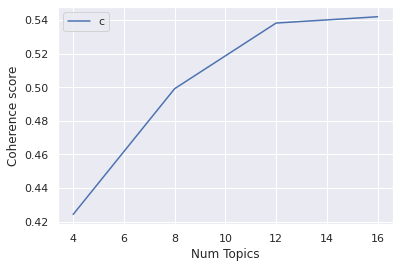

In [41]:
limit=20; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.4242
Num Topics = 8  has Coherence Value of 0.4991
Num Topics = 12  has Coherence Value of 0.5382
Num Topics = 16  has Coherence Value of 0.542


In [43]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"follow" + 0.013*"constantly" + 0.013*"realize" + 0.012*"skill" + '
  '0.012*"personal" + 0.012*"lead" + 0.010*"simply" + 0.009*"search" + '
  '0.009*"set" + 0.009*"push"'),
 (1,
  '0.018*"lose" + 0.017*"break" + 0.016*"stop" + 0.012*"fast" + 0.011*"line" + '
  '0.010*"fly" + 0.009*"minute" + 0.009*"buy" + 0.009*"money" + 0.009*"jump"'),
 (2,
  '0.023*"student" + 0.023*"degree" + 0.022*"computer" + 0.020*"design" + '
  '0.016*"project" + 0.016*"finish" + 0.015*"major" + 0.013*"build" + '
  '0.012*"technology" + 0.012*"tech"'),
 (3,
  '0.018*"east" + 0.018*"language" + 0.017*"decide" + 0.016*"finally" + '
  '0.015*"state" + 0.015*"native" + 0.014*"living" + 0.014*"meeting" + '
  '0.014*"past" + 0.013*"return"'),
 (4,
  '0.022*"artist" + 0.019*"draw" + 0.017*"photography" + 0.015*"band" + '
  '0.015*"sing" + 0.015*"song" + 0.013*"guitar" + 0.012*"comedy" + '
  '0.012*"writing" + 0.011*"paint"'),
 (5,
  '0.022*"confident" + 0.021*"witty" + 0.019*"quality" + 0.018*"thoughtful

In [45]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1231,"hot, dress, morning, sun, garden, burn, tree, ...",about me: i would love to think that i was so...
1,1,13.0,0.0942,"concert, climb, giant, summer, tennis, footbal...",i am a chef: this is what that means. 1. i am ...
2,2,14.0,0.1632,"situation, matter, problem, wrong, reason, eas...","i'm not ashamed of much, but writing public te..."
3,3,0.0,0.0625,"follow, constantly, realize, skill, personal, ...",i work in a library and go to school. . .
4,4,7.0,0.0982,"picture, answer, lol, weird, okcupid, fill, ph...",hey how's it going? currently vague on the pro...
5,5,4.0,0.1113,"artist, draw, photography, band, sing, song, g...","i'm an australian living in san francisco, but..."
6,6,6.0,0.0990,"connection, practice, connect, beauty, soul, s...",life is about the little things. i love to lau...
7,7,4.0,0.1387,"artist, draw, photography, band, sing, song, g...",my names jake. i'm a creative guy and i look f...
8,8,7.0,0.1194,"picture, answer, lol, weird, okcupid, fill, ph...","update: i'm seeing someone, so off the market ..."
9,9,3.0,0.1177,"east, language, decide, finally, state, native...","i was born in wisconsin, grew up in iowa, and ..."


In [47]:
from gensim.test.utils import datapath
temp_file = datapath("/content/drive/MyDrive/lda_model_tj")

optimal_model.save(temp_file)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [48]:
from gensim import  models

lda = models.ldamodel.LdaModel.load(temp_file)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
